In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import gc
# import cupy as cp


from statsmodels.formula.api import ols

import scipy.cluster.hierarchy as scipy_hierarchy
from scipy.spatial.distance import squareform
from scipy import stats


from sklearn.decomposition import PCA

In [2]:
# GENERAL CONFIGURATION FOR THE ANALYSIS:
# Adjacency type affects how the adjacency matrix is calculated. The signed method, im not sure if it makes sense
adjacency_type = "unsigned"

In [3]:
# SETTINGS FOR PLOTTING FIGURES
PLOTS_WANTED = True
dpi_general = 150

# Settings for printing dataframes
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

In [4]:
# Colors for the terminal outputs
ENDC = "\033[0m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"

OKBLUE = "\033[94m"
OKGREEN = "\033[92m"
WARNING = "\033[93m"
FAIL = "\033[91m"

TESTING DATA

In [ ]:
## Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')



## Load the dataset
# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
transcriptomics_dataset_testing_dir = working_dir + 'data/5xFAD_paper/expressionList.csv'  
transcriptomics_dataset_testing = pd.read_csv(transcriptomics_dataset_testing_dir, index_col=0)

# Sample info and Clinical Traits Data
sample_info_traits_dir = working_dir + 'data/5xFAD_paper/sampleInfo.csv'
trait_dataset = pd.read_csv(sample_info_traits_dir)

# Figures Saving output dir
figures_dir = working_dir + 'results/WGCNA_figures_5xFAD/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")


#transcriptomics_dataset = transcriptomics_dataset_testing

'''
## Make a subset to save RAM
subset_dataset_size = 30000
transcriptomics_dataset = transcriptomics_dataset_testing.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")
'''


REAL DATA FROM THE LAB

In [5]:
### LOADING REAL UNPUBLISHED DATA    -     NO PUSHING FOR THE RESULTS

# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')
data_dir = working_dir + 'data/PROTECTED_DATA/BGI_Expression_Data/'



## Load the dataset
# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
# transcriptomics_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.count.csv'  
# transcriptomics_dataset = pd.read_csv(transcriptomics_dataset_dir, index_col=0)

# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
transcriptomics_TPM_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_TPM_dataset_dir, index_col=0)

# Sample info and Clinical Traits Data
# Sample info and Clinical Traits Data
sample_info_traits_dir = data_dir + 'Sample_Info_Selection.csv'
trait_dataset = pd.read_csv(sample_info_traits_dir)
trait_dataset


# Figures Saving output dir
figures_dir = working_dir + 'results/WGCNA_figures_BGI_TPM_prepro_newparam/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")



## Make a subset to save RAM
subset_dataset_size = 200
transcriptomics_dataset = transcriptomics_dataset.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")


The aproximated RAM to analyse this size of dataset is: 0.0002980232238769531 GB


In [6]:
transcriptomics_dataset

,A1BG,A1CF,A2M,A2ML1,A3GALT2,...,ACSM4,ACSM5,ACSM6,ACSS1,ACSS2
Sample_ID,,,,,,,,,,,
CRC.SW.U0001.T,0.59,17.19,699.63,0.01,0.00,...,0.04,0.10,0.00,39.16,103.21
CRC.SW.U0002.T,0.15,22.14,271.97,0.04,0.00,...,0.00,0.32,0.71,37.53,108.26
CRC.SW.U0004.T,0.75,23.09,221.77,0.01,0.00,...,0.00,0.00,0.10,47.06,101.84
CRC.SW.U0005.T,0.14,10.17,521.99,0.13,0.00,...,0.00,0.14,0.34,29.40,83.50
CRC.SW.U0006.T,0.14,7.18,123.65,0.05,0.00,...,0.00,0.21,0.00,32.55,112.54
...,...,...,...,...,...,...,...,...,...,...,...
CRC.SW.UM169.T,0.00,18.61,118.94,0.03,0.00,...,0.16,0.03,0.00,19.53,118.17
CRC.SW.UM170.T,0.00,18.95,116.77,0.03,0.00,...,0.09,0.11,0.17,18.86,53.17
CRC.SW.UM171.T,0.00,20.27,33.46,0.15,0.19,...,0.12,0.11,0.22,20.70,122.90


Pre-processing...
0 genes were removed due to having 0 variation across samples...


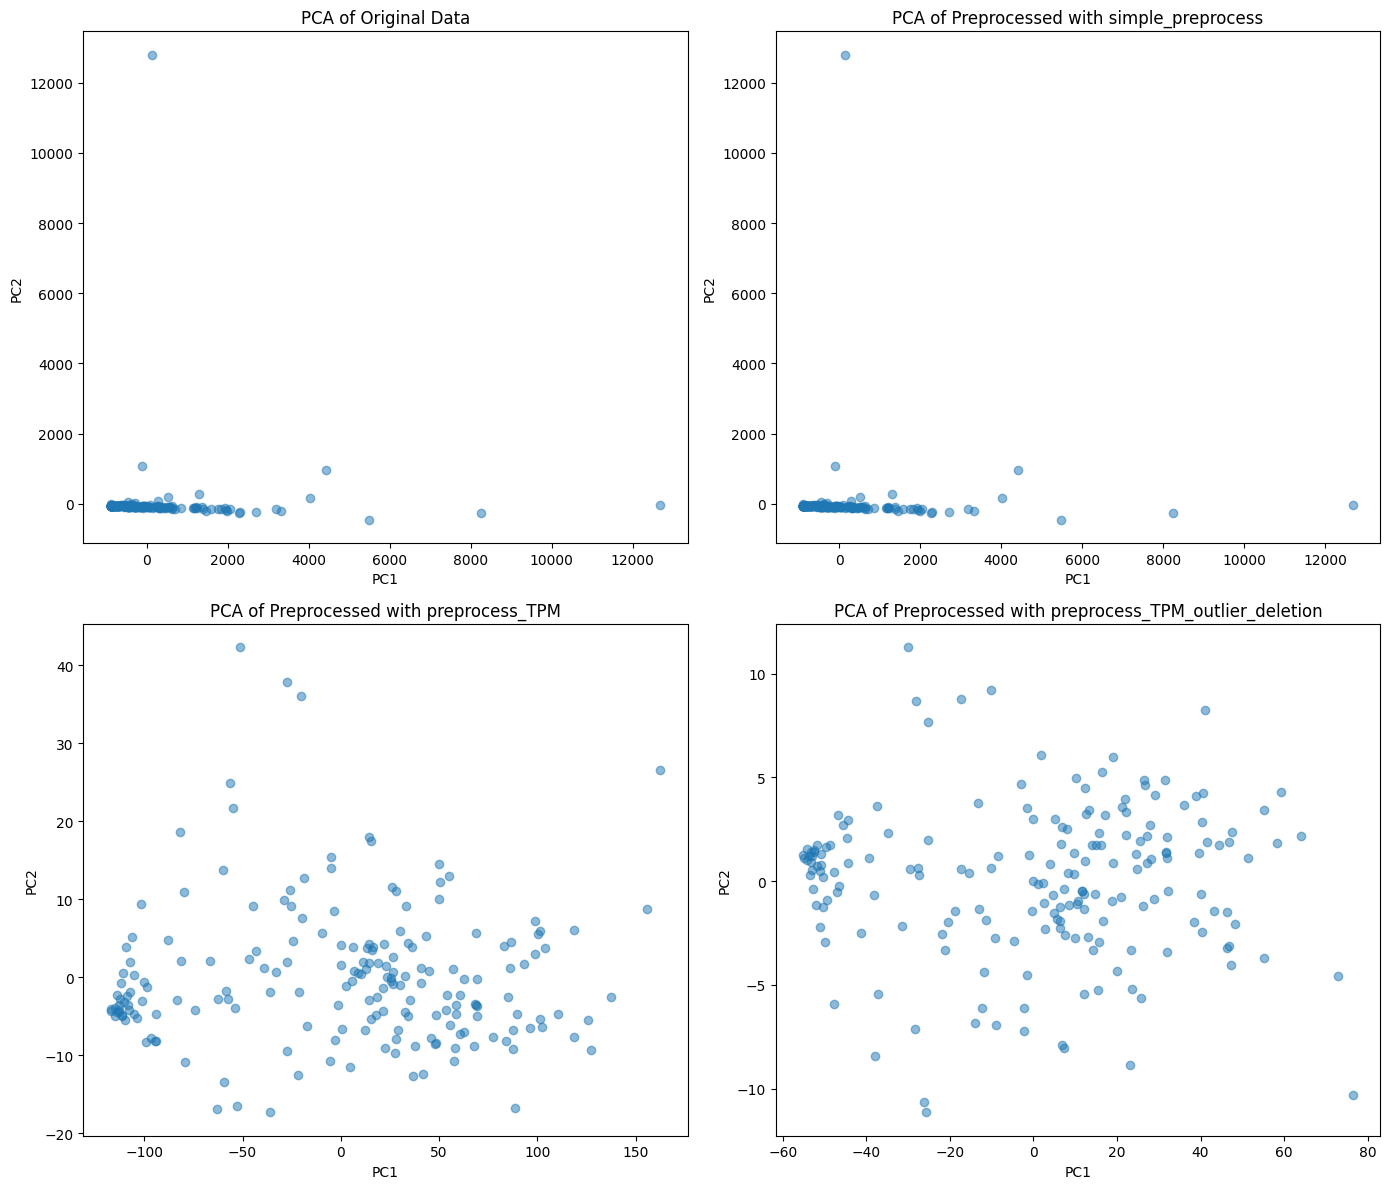

Done...


In [7]:
### Step 1: Data Preprocessing (Normalization)
## Preprocessing: removing obvious outlier on genes and samples
print(f"{BOLD}{OKBLUE}Pre-processing...{ENDC}")



## Prepare and clean data
def preprocess_TPM_outlier_deletion(raw_data):
    '''
    
    
    '''
    # Step 1: Filter out genes with low expression across all samples
    # Threshold set so that a gene needs to be expressed TPM > 1 in at least 10% of samples
    expression_th = 1
    cleaned_dataset = raw_data.loc[:, (raw_data > expression_th).any(axis=0)].copy()
    
    # Step 2: Log transformation
    cleaned_dataset.iloc[:, 1:] = np.log2(cleaned_dataset.iloc[:, 1:] + 1)
    
    # Step 3: Outlier detection and removal based on PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(cleaned_dataset.iloc[:, 1:].T)  # Transpose to have samples as rows for PCA
    z_scores = np.abs(stats.zscore(pca_result, axis=0))
    good_samples = (z_scores < 3).all(axis=1)  # Keeping samples within 3 standard deviations
    cleaned_dataset = cleaned_dataset.iloc[:, [True] + good_samples.tolist()]  # True for gene identifiers column
    
    # Step 7: Data Standardization (Z-score normalization)
    cleaned_dataset.iloc[:, 1:] = cleaned_dataset.iloc[:, 1:].apply(stats.zscore, axis=1)

    
    return cleaned_dataset




## Prepare and clean data
def preprocess_TPM(raw_data):
    '''
    
    
    '''
    # Step 1: Filter out genes with low expression across all samples
    # Threshold set so that a gene needs to be expressed TPM > 1 in at least 10% of samples
    expression_th = 1
    cleaned_dataset = raw_data.loc[:, (raw_data > expression_th).any(axis=0)].copy()
    
    # Step 2: Log transformation
    cleaned_dataset.iloc[:, 1:] = np.log2(cleaned_dataset.iloc[:, 1:] + 1)
    
    return cleaned_dataset




## Prepare and clean data
def simple_preprocess(raw_data):
    '''
    
    
    '''
    # Step 1: Filter out genes with low expression across all samples
    # Threshold set so that a gene needs to be expressed TPM > 1 in at least 10% of samples## Remove genes with no variation across samples (0 vectors) 
    cleaned_dataset = raw_data.loc[:, (raw_data != 0).any(axis=0)] # Actually droping columns with 0 variation

    # Also print how many genes have been removed in this steo
    num_genes_removed = raw_data.shape[1] - cleaned_dataset.shape[1]
    print(f"{BOLD}{WARNING}{num_genes_removed} genes were removed due to having 0 variation across samples...{ENDC}")
    
    return cleaned_dataset

    
# Plotting PCA function for visualization
def plot_pca(dataframe, title='PCA before and after preprocessing', ax=None):
    """
    Performs PCA on the provided dataframe and plots the first two principal components.
    """
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe.iloc[:, 1:].T)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')




# Visualize original and preprocessed data with PCA
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot each PCA visualization
plot_pca(transcriptomics_dataset, title='PCA of Original Data', ax=axs[0, 0])
plot_pca(simple_preprocess(transcriptomics_dataset), title='PCA of Preprocessed with simple_preprocess', ax=axs[0, 1])
plot_pca(preprocess_TPM(transcriptomics_dataset), title='PCA of Preprocessed with preprocess_TPM', ax=axs[1, 0])
plot_pca(preprocess_TPM_outlier_deletion(transcriptomics_dataset), title='PCA of Preprocessed with preprocess_TPM_outlier_deletion', ax=axs[1, 1])
plt.tight_layout()
plt.show()




# Pick the preprocessing to actually use:
transcriptomics_dataset_filtered = preprocess_TPM_outlier_deletion(transcriptomics_dataset)


print(f"{BOLD}{OKBLUE}Done...{ENDC}")

Calculating Correlation Matrix...
Enforced max and min values to compensate for Floating point misshandles in python.


Done.


Plotting and Saving the Correlation Matrix...


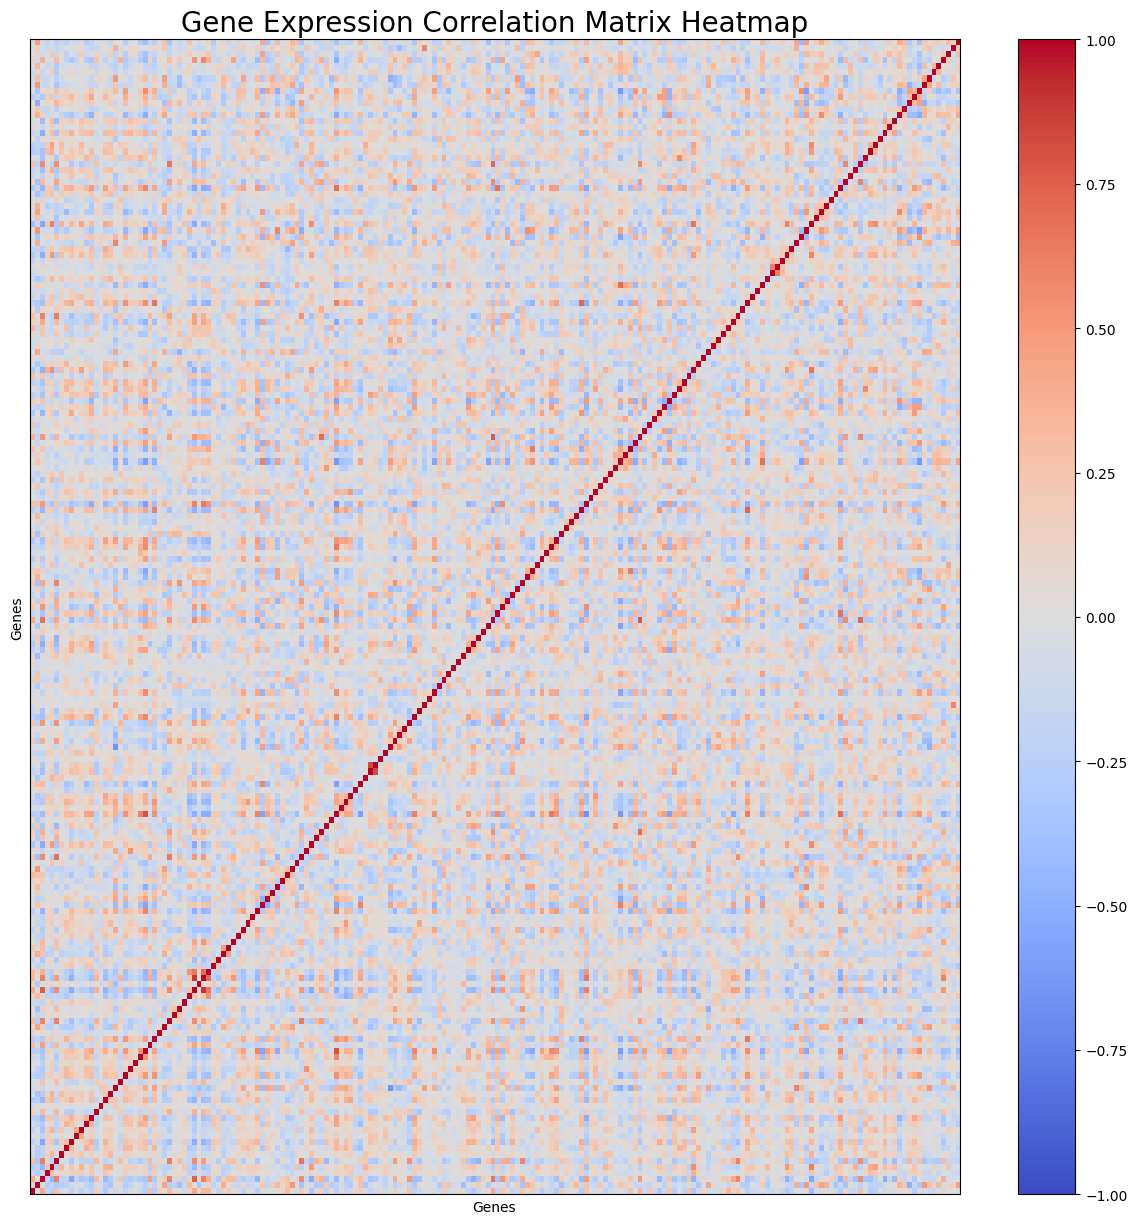

Done


In [8]:
### Step 2: Constructing a Co-expression Similarity Matrix (Correlation Matrix)
'''
The Correlation matrix, also known as Co-expression Matrix or Similarity matrix is calculated by
calculating the correlation between the expression profiles of all genes. The expression profile of 
a gene is a vector containing the expression levels of that gene for all samples (pacients)
'''


print(f"{BOLD}{OKBLUE}Calculating Correlation Matrix...{ENDC}")

## Calculate the correlation matrix using Pearson correlation
# Since Pandas correlation is extreamly slow, we switched to numpy
# for CuPy implementaiton, see WGCNA_CuPy_impl.ipynb
np_transcriptomics_dataset = transcriptomics_dataset_filtered.T.to_numpy()
correlation_matrix_np = np.corrcoef(np_transcriptomics_dataset)



# Enforce ranges in matrix python handling Floating poin incorrectly 
correlation_matrix_np = np.clip(correlation_matrix_np, -1.0, 1.0)
print(f"{BOLD}{FAIL}Enforced max and min values to compensate for Floating point misshandles in python.\n\n{ENDC}")

# Also fix the diagonal
np.fill_diagonal(correlation_matrix_np, 1)



print(f"{BOLD}{OKBLUE}Done.\n\n{ENDC}")



## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Correlation Matrix...{ENDC}")
    title_figure = 'Gene Expression Correlation Matrix Heatmap'
    
    # using pcolorfast for speed
    fig, ax = plt.subplots(figsize=(15, 15))
    cax = ax.pcolorfast(correlation_matrix_np, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(cax)

    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()




print(f"{BOLD}{OKBLUE}Done{ENDC}")


In [ ]:
### TEST TO ENSURE THAT PYTHON IS NOT BREAKING THE MATHS BY POOR-HANDELING THE FLOATS

# Check if any values are out of range
min_value_allowed = -1
max_value_allowed = 1

smaller_values_check = not((correlation_matrix_np < min_value_allowed).any().any())
bigger_values_check = not((correlation_matrix_np > max_value_allowed).any().any())

# Print check of values out of range
print(f'Are all values >= {min_value_allowed}?  {smaller_values_check}') 
print(f'Are all values <= {max_value_allowed}?  {bigger_values_check}')
print('\n')

# For visual inspection print biggest and smallest value in the Dataframe
print(f'The biggest value in this matrix is: {correlation_matrix_np.max().max()}\
\nThe smallest value in this matrix is: {correlation_matrix_np.min().min()}')
print('\n')


# Check if it is an issue with the diagonal
expected_diagonal = 1
diagonal = np.diag(correlation_matrix_np)
all_equal_to_expected = np.all(diagonal == expected_diagonal)
print(f'All the values in the diagonal are euqal to the expected value of {expected_diagonal}?   {all_equal_to_expected}')


In [ ]:
### Step 3: Transforming into an adjacency matrix using a soft threshold power
print(f"{BOLD}{OKBLUE}Transforming Correlation Matrix into Adjacency Matrix...{ENDC}")



####################################### FUNCTIONS #######################################

### Function that checks if the adjacency matrix resembles a scale-free network topology (following a power-law distribution).
def scaleFreeFitIndex(connectivity, block_size=10):  # values and code highly taken from pyWGCNA, only small adaptations
    """
    Calculates several fitting statistics to evaluate scale free topology fit.


    block_size = Size of the blocks in which the connectivity is discretized
    """
    

    # Ensure all data is non zero
    connectivity = connectivity[connectivity > 0]

    # Turn the connectivity into a dataframe, and discretize into blocks of block_size size
    connectivity = pd.DataFrame({'data': connectivity})
    connectivity['discretized_connectivity'] = pd.cut(connectivity['data'], block_size)

    # Calculate mean connectivity, probability density for each block
    per_block_stats = connectivity.groupby('discretized_connectivity', observed=False)['data'].agg(['mean', 'count']) \
                            .reset_index().rename(columns={'mean': 'mean_connectivity_per_block', 'count': 'count_per_block'})
    per_block_stats['probability_density_per_block'] = per_block_stats['count_per_block'] / len(connectivity)

    # Handle blocks with no values or zero connectivity
    breaks = np.linspace(start=connectivity['data'].min(), stop=connectivity['data'].max(), num=block_size + 1)
    mid_points_blocks = 0.5 * (breaks[:-1] + breaks[1:])  # Mid-points of blocks

    # Impute missing or zero values with block midpoints
    for i, row in per_block_stats.iterrows():
        if pd.isnull(row['mean_connectivity_per_block']) or row['mean_connectivity_per_block'] == 0:
            per_block_stats.at[i, 'mean_connectivity_per_block'] = mid_points_blocks[i]


    # Logarithmic transformation
    per_block_stats['log_mean_conn'] = np.log10(per_block_stats['mean_connectivity_per_block'])
    per_block_stats['log_prob_distr_conn'] = np.log10(per_block_stats['probability_density_per_block'] + 1e-9)

    # Linear regression Model
    simple_linear_regression_model = ols('log_prob_distr_conn ~ log_mean_conn', data=per_block_stats).fit()
    rsquared = simple_linear_regression_model.rsquared
    slope = simple_linear_regression_model.params['log_mean_conn']
    
    # Quadratic Regression Model for Adjusted R-squared
    quadratic_regression_model = ols('log_prob_distr_conn ~ log_mean_conn + I(log_mean_conn**2)', data=per_block_stats).fit()
    rsquared_adj = quadratic_regression_model.rsquared_adj

    return pd.DataFrame({
        'Rsquared.SFT': [rsquared],
        'slope.SFT': [slope],
        'Rsquared Adjusted': [rsquared_adj]
    })



### Function that analyses the network topology of the dataset
def pickSoftThreshold(correlation_matrix, RsquaredCut, MeanCut):
    """
    Analyzes scale-free topology for multiple soft thresholding powers.
    Soft power-thresholding is a value used to power each value of the correlation matrix of the genes to that threshold.
    The assumption is that by raising the correlation values to a power, we will reduce the noise of the correlations in
    the adjacency matrix, therefore putting in relevance important links and tuning down the noise.

    To pick up the threshold, the pickSoftThreshold function calculates for each possible power if the network resembles
    a scale-free network topology (following a power-law distribution).
    The power which produce a higher similarity with a scale-free network is the one returned.

    This is critical in WGCNA, as the premise of the method is that biological networks often exhibit scale-free properties, 
    meaning that a few nodes (genes) are highly connected, while most have few connections.

    
    RsquaredCut: Threshold for the R^2 statistic
    MeanCut: Threshold for the Mean Connectivity statistic
    """

    powerVector = list(range(1, 11)) + list(range(12, 21, 2))  # values taken from pyWGCNA package

    # Initialize output DataFrame
    results = pd.DataFrame(index=powerVector, columns=["Power"])



    ## Build and adjacency matrix with each power, and test its fit to scale-free network topology
    for power in powerVector:
        # Calculate adjacency matrix from the correlation_matrix with each power
        adjacency_matrix = np.power(np.abs(correlation_matrix), power)
        
        # Calculate connectivity for each node/gene
        connectivity = adjacency_matrix.sum(axis=0) - 1  # we remove the autocorrelation for each row
        
        # Check the resemblance to a scale-free network topology 
        fit_values = scaleFreeFitIndex(connectivity)
        
        # Store results
        results.loc[power, "Power"] = power
        results.loc[power, "R²"] = fit_values['Rsquared.SFT'].values[0]
        results.loc[power, "Slope"] = fit_values['slope.SFT'].values[0]
        results.loc[power, "Exponential R² Adjusted"] = fit_values['Rsquared Adjusted'].values[0]
        results.loc[power, "mean(connectivity)"] = connectivity.mean()
        results.loc[power, "median(connectivity)"] = connectivity.median()
        results.loc[power, "max(connectivity)"] = connectivity.max()
    print(results)


    ## Select the power with the best fit
    valid_powers = results[(results["R²"] > RsquaredCut) & (results["mean(connectivity)"] < MeanCut)]
    if not valid_powers.empty:
        optimal_power = valid_powers.index[0]
    else:
        optimal_power = results["R²"].idxmax()


    print(f"{BOLD}{OKGREEN}The optimal Power-Threshold found is {optimal_power}.{ENDC}")
    return optimal_power, results






## Choosing the soft-thresholding power: analysis of network topology based on the dataset
RsquaredCut = 0.8   # Values from pyWGCNA
MeanCut = 100       # Values from pyWGCNA

# Temporary turning back to pandas, but should be reimplemented with numpy
correlation_matrix = pd.DataFrame(correlation_matrix_np, columns=transcriptomics_dataset_filtered.columns, index=transcriptomics_dataset_filtered.columns)

print(f"{BOLD}{OKBLUE}Starting Soft Power-Thresholding algorithmic search ...{ENDC}")
optimal_power, results = pickSoftThreshold(correlation_matrix, RsquaredCut, MeanCut) 
print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")

# Plotting the results
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving Scale-Free Topology fit analysis...{ENDC}")
    title_figure1 = 'Scale-Free Topology Analysis'
    title_figure2 = 'Mean Connectivity'

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting Scale-Free Topology Analysis
    axs[0].plot(results.index, results["R²"], marker='o', linestyle='-', label='Scale-Free Topology Fit R^2')
    axs[0].axhline(y=RsquaredCut, color='red', linestyle='--', label=f'R^2 cut-off: {RsquaredCut}')
    axs[0].axvline(x=optimal_power, color='green', linestyle='-', label=f'Optimal Power: {optimal_power}')
    axs[0].set_xlabel('Soft Thresholding Power')
    axs[0].set_ylabel('Scale-Free Topology Fit R^2')
    axs[0].set_title(title_figure1, fontsize=20)
    axs[0].legend()

    # Plotting Mean Connectivity vs. Soft Thresholding Power
    mean_connect_optimal_power = results.loc[optimal_power, 'mean(connectivity)']
    axs[1].plot(results.index, results['mean(connectivity)'], marker='o', linestyle='-', color='blue', label='Mean Connectivity')
    axs[1].axhline(y=mean_connect_optimal_power, color='red', linestyle='--', label=f'Mean Conn at Opt-Power: {mean_connect_optimal_power:.3f}')
    axs[1].axvline(x=optimal_power, color='green', linestyle='--', label=f'Optimal Power: {optimal_power}')
    axs[1].set_xlabel('Soft Thresholding Power')
    axs[1].set_ylabel('Mean Connectivity')
    axs[1].set_title(title_figure2, fontsize=20)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(figures_dir + title_figure1 + " and " + title_figure2, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")





## Making the adjacency  matrix out of the correlation matrix, based on the soft-thresholding power selected
print(f"{BOLD}{OKBLUE}Calculating Adjacency Matrix...{ENDC}")

adjacency_type = adjacency_type
if adjacency_type == "unsigned":
    adjacency_matrix_np = np.power(np.abs(correlation_matrix_np), optimal_power)
elif adjacency_type == 'signed':
    correlation_matrix_np = (correlation_matrix_np + 1) / 2
    adjacency_matrix_np = np.power(correlation_matrix_np, optimal_power)

# Enforce ranges in matrix
adjacency_matrix_np = np.clip(adjacency_matrix_np, 0.0, 1.0)

print(f"{BOLD}{FAIL}Enforced max and min values to compensate for Floating point misshandles in python.\n\n{ENDC}")


# Also fix the diagonal
np.fill_diagonal(adjacency_matrix_np, 1)
    

print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")





## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Adjacency Matrix...{ENDC}")
    title_figure = 'Adjacency Matrix Heatmap'

    # plt.figure(figsize=(15, 15))
    # sns.heatmap(adjacency_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)

    # using pcolorfast for speed
    fig, ax = plt.subplots(figsize=(15, 15))
    cax = ax.pcolorfast(adjacency_matrix_np, cmap='coolwarm', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(cax)

    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")



In [ ]:
### TEST TO ENSURE THAT PYTHON IS NOT BREAKING THE MATHS BY POOR-HANDELING THE FLOATS

# Check if any values are out of range
min_value_allowed = 0
max_value_allowed = 1

smaller_values_check = not((adjacency_matrix_np < min_value_allowed).any().any())
bigger_values_check = not((adjacency_matrix_np > max_value_allowed).any().any())

# Print check of values out of range
print(f'Are all values >= {min_value_allowed}?  {smaller_values_check}') 
print(f'Are all values <= {max_value_allowed}?  {bigger_values_check}')
print('\n')

# For visual inspection print biggest and smallest value in the Dataframe
print(f'The biggest value in this matrix is: {adjacency_matrix_np.max().max()}\
\nThe smallest value in this matrix is: {adjacency_matrix_np.min().min()}')
print('\n')


# Check if it is an issue with the diagonal
expected_diagonal = 1
diagonal = np.diag(adjacency_matrix_np)
all_equal_to_expected = np.all(diagonal == expected_diagonal)
print(f'All the values in the diagonal are euqal to the expected value of {expected_diagonal}?   {all_equal_to_expected}')

In [ ]:
### Cleaning Ram 
del transcriptomics_dataset, correlation_matrix_np, correlation_matrix
gc.collect()

In [ ]:
### Step 4: Converting adjacency matrix into a topological overlap matrix (TOM)
print(f"{BOLD}{OKBLUE}Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...{ENDC}")



####################################### FUNCTIONS #######################################
def calculate_tom(numeric_adjacency_matrix, TOMDenom, adjacency_type):
    '''
    Revisit this function now that i have the source code of the R package in C
    '''

    '''
    This function takes the adjacency matrix and calculates the Topological Overlap Matrix (TOM) from it.
    This matrix is a similarity matrix, using as the similarity metric the amount of genes that two genes 
    have in common, therefore the overlap of neighbors between two genes.

    
    TOMType:  Unsigned or Signed topologies
    TOMDenom: A character string specifying the TOM variant to be used. Recognized values are "min" giving the standard TOM described 
                in Zhang and Horvath (2005), and "mean" in which the min function in the denominator is replaced by mean. The "mean" 
                may produce better results but at this time should be considered experimental.
    '''

    # Turn the Adjacency matrix diagonl to 0 for calculations
    np.fill_diagonal(numeric_adjacency_matrix, 0)

    # Calculate numerator as A^2
    numerator = np.dot(numeric_adjacency_matrix, numeric_adjacency_matrix)

    # Denominator calculation based on TOMDenom selection
    row_sum = numeric_adjacency_matrix.sum(axis=1)
    col_sum = numeric_adjacency_matrix.sum(axis=0)
    # Calculations deppending on the selectod method
    if TOMDenom == 'min':
        denominator = np.minimum.outer(row_sum, col_sum)
    elif TOMDenom == 'mean':
        denominator = (np.outer(row_sum, np.ones_like(row_sum)) + np.outer(np.ones_like(col_sum), col_sum)) / 2


     # Numerator adjustment for unsigned and signed topologies
    if adjacency_type == 'unsigned':
        tom = (numerator + numeric_adjacency_matrix) / (denominator + 1 - numeric_adjacency_matrix)
    elif adjacency_type == 'signed':
        tom = np.abs(numerator + numeric_adjacency_matrix) / (denominator + 1 - np.abs(numeric_adjacency_matrix))

    
    
    # Set diagonal to 1 as per TOM definition
    np.fill_diagonal(tom, 1)  

    # Handle NaN values and set them to zero
    tom = np.nan_to_num(tom, nan=0)

    # Convert back to DataFrame
    #tom = pd.DataFrame(tom, index=adjacency_matrix.index, columns=adjacency_matrix.columns)

    return tom






## Calculating the TOM from the Adjacency Matrix
# TOMDenom must be either 'min' or 'mean'. More explanation in the function itself
TOMDenom = "mean"

print(f"{BOLD}{OKBLUE}Calculating the TOM...{ENDC}")
simTOM_np = calculate_tom(adjacency_matrix_np, TOMDenom, adjacency_type)
dissTOM_np = 1 - simTOM_np

print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")






## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the TOM...{ENDC}")
    title_figure = 'Topological Overlap Matrix (TOM) Heatmap'

    # plt.figure(figsize=(15, 15))
    # sns.heatmap(simTOM, cmap='coolwarm', xticklabels=False, yticklabels=False)

    # using pcolorfast for speed
    fig, ax = plt.subplots(figsize=(15, 15))
    cax = ax.pcolorfast(simTOM_np, cmap='coolwarm', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(cax)

    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")


In [ ]:
### TEST TO ENSURE THAT PYTHON IS NOT BREAKING THE MATHS BY POOR-HANDELING THE FLOATS

# Check if any values are out of range
min_value_allowed = 0
max_value_allowed = 1

smaller_values_check = not((simTOM_np < min_value_allowed).any().any())
bigger_values_check = not((simTOM_np > max_value_allowed).any().any())

# Print check of values out of range
print(f'Are all values >= {min_value_allowed}?  {smaller_values_check}') 
print(f'Are all values <= {max_value_allowed}?  {bigger_values_check}')
print('\n')

# For visual inspection print biggest and smallest value in the Dataframe
print(f'The biggest value in this matrix is: {simTOM_np.max().max()}\
\nThe smallest value in this matrix is: {simTOM_np.min().min()}')
print('\n')


# Check if it is an issue with the diagonal
expected_diagonal = 1
diagonal = np.diag(simTOM_np)
all_equal_to_expected = np.all(diagonal == expected_diagonal)
print(f'All the values in the diagonal are euqal to the expected value of {expected_diagonal}?   {all_equal_to_expected}')


In [ ]:
### Cleaning Ram 
del adjacency_matrix_np, simTOM_np
gc.collect()

In [ ]:
### Step 5: Hierarchical clustering
## We use a dendogram where the distances are taken from the dissTOM 


print(f"{BOLD}{OKBLUE}Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...{ENDC}")
# Take only one half of the TOM matrix, since it is square and symmetrix
condensed_dissTOM = squareform(dissTOM_np, checks=False)

## Do the Hierarchical clustering
# The different methods can be: "single", "complete", "average", "weighted", "centroid"]
method = "average"  
linkage_matrix = scipy_hierarchy.linkage(condensed_dissTOM, method=method)
print(f"{BOLD}{OKBLUE}Done...\n\n{ENDC}")


## Plot the dendrogram
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Dendogram from the Hierarchical clustering...{ENDC}")
    title_figure = 'Dendogram from the Hierarchical clustering'

    plt.figure(figsize=(15, 10))
    scipy_hierarchy.dendrogram(linkage_matrix, truncate_mode=None, color_threshold=0)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Distance taken from the TOM', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")

In [ ]:
### Step 6: Module identification
print(f"{BOLD}{OKBLUE}Finding Modules from the Dendogram with a Tree-Cutting Algorithm...{ENDC}")



####################################### FUNCTIONS #######################################
def identify_modules(linkage_matrix, dist_matrix, min_memb_cluster, deep_split):
    """
    Enhanced module identification mimicking cutreeHybrid's functionality.
    """
    
    max_d = max(linkage_matrix[:, 2])
    cutHeight = np.percentile(linkage_matrix[:, 2], 95)



    ## Cluster Assignment
    cluster_labels = scipy_hierarchy.fcluster(linkage_matrix, t=cutHeight, criterion='distance')



    ## Core Scatter and Gap Analysis
    # calculate the average within-cluster distance (as a proxy for core scatter) 
    # and the minimum inter-cluster distance (as a proxy for the gap)
    n_clusters = np.max(cluster_labels)
    core_scatters = []
    gaps = []
    
    for i in range(1, n_clusters + 1):
        within_cluster_distances = dist_matrix[np.ix_(cluster_labels == i, cluster_labels == i)]
        between_cluster_distances = dist_matrix[np.ix_(cluster_labels == i, cluster_labels != i)]
        
        # Calculate core scatter as the average within-cluster distance
        core_scatter = np.mean(within_cluster_distances[np.triu_indices_from(within_cluster_distances, k=1)])
        core_scatters.append(core_scatter)
        
        # Calculate gap as the minimum between-cluster distance
        gap = np.min(between_cluster_distances) if between_cluster_distances.size > 0 else np.inf
        gaps.append(gap)
    
    # DataFrame with these metrics for each cluster.
    cluster_metrics = pd.DataFrame({'Cluster': range(1, n_clusters + 1), 'CoreScatter': core_scatters, 'Gap': gaps})



    ## Handling Small Clusters and Singletons
    # merging small clusters and reassigning singletons.
    unique_clusters = np.unique(cluster_labels)
    cluster_sizes = {cluster: np.sum(cluster_labels == cluster) for cluster in unique_clusters}
    small_clusters = [cluster for cluster, size in cluster_sizes.items() if size < min_memb_cluster]
    
    # Process small clusters and singletons
    for small_cluster in small_clusters:
        members = np.where(cluster_labels == small_cluster)[0]
        
        # If it's a singleton, find the closest cluster to merge into
        if len(members) == 1:
            distances = dist_matrix[members, :]
            # Mask distances within the same cluster
            distances[distances == 0] = np.inf
            closest_cluster = np.argmin(np.min(distances, axis=1))
            new_label = cluster_labels[closest_cluster]
            
            # Reassign the singleton to the closest cluster
            cluster_labels[members] = new_label
        else:
            # For small clusters, consider merging logic or leave as is for simplicity
            pass



    return module_assignment, cut_height




def identify_modules_simple_version(linkage_matrix, height_percentile, min_memb_cluster):
    '''
    Very Basic first approach (written out of what I know about tree cutting) to extract flat clusters (gene modules)
    out of the Dendogram, trying to make it balanced with dynamic parameters.

    Genes that are not assigned to any module will be identified as Module 0
    '''


    # Dynamically set parameters based on dendrogram size
    cut_height_percentile = np.percentile(linkage_matrix[:, 2], height_percentile)
    
    # Set cut_height based on dynamic sensitivity
    max_dendro_height = np.max(linkage_matrix[:, 2])
    sensitivity = max_dendro_height / cut_height_percentile
    cut_height = max_dendro_height / sensitivity

    # Form flat clusters from the dendogram
    cluster_labels = scipy_hierarchy.fcluster(linkage_matrix, t=cut_height, criterion='distance')

    # Map genes to their cluster labels in a dataframe
    module_assignment = pd.DataFrame({'Gene': range(1, len(cluster_labels) + 1), 'Module': cluster_labels})

    # Filter out small modules and join them to the Module 0 (no cluster)
    module_sizes = module_assignment['Module'].value_counts()
    small_modules = module_sizes[module_sizes < min_memb_cluster].index
    module_assignment['Module'] = module_assignment['Module'].apply(lambda x: 0 if x in small_modules else x)

    # Reassign module labels to be consecutive for non-zero modules
    non_zero_modules = module_assignment[module_assignment['Module'] != 0]['Module']
    unique_non_zero_modules = pd.Categorical(non_zero_modules).codes + 1
    module_assignment.loc[module_assignment['Module'] != 0, 'Module'] = unique_non_zero_modules

    return module_assignment, cut_height




min_memb_cluster = 20
height_percentile = 45  # Use the percentile of heights to set sensitivity
module_assignment, cut_height = identify_modules_simple_version(linkage_matrix, height_percentile, min_memb_cluster)

deep_split=2 # Provides a rough control over sensitivity to cluster splitting. The higher the value, the more and smaller clusters will be produced. (default = 1)
# module_assignment, cut_height = identify_modules(linkage_matrix, condensed_dissTOM, min_memb_cluster, deep_split)

# Add the Gene name to the clustering table
module_assignment.insert(0, 'Gene Name', list(transcriptomics_dataset_filtered))






## Plot the dendrogram
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Dendogram with the modules found with dynamic tree-cutting...{ENDC}")
    title_figure = 'Dendogram after tree-cutting'

    plt.figure(figsize=(15, 10)) 
    scipy_hierarchy.dendrogram(linkage_matrix, color_threshold=cut_height, no_labels=True)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Colored following Gene Modules after dynamic tree-cutting', fontsize=10)
    plt.axhline(y=cut_height, color='r', linestyle='--')
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")

print(module_assignment['Module'].value_counts())

In [ ]:
################################################################################################
#                       TERRIBLE CODE FROM pyWGCNA          
################################################################################################
from scipy.cluster.hierarchy import to_tree
from scipy.stats import rankdata
import math
import scipy.stats as stats


def get_heights(Z):

    clusternode = to_tree(Z, True)
    height = np.array([c.dist for c in clusternode[1] if c.is_leaf() is not True])

    return height

def get_merges(z):
    n = z.shape[0]
    merges = np.zeros((z.shape[0], 2), dtype=int)

    for i in range(z.shape[0]):
        for j in range(2):
            if z[i][j] <= n:
                merges[i][j] = -(z[i][j] + 1)
            else:
                cluster = z[i][j] - n
                merges[i][j] = cluster

    return merges

def interpolate(data, index):
    i = round(index)
    n = len(data)
    if i < 1:
        return data[1]
    if i >= n:
        return data[n]
    r = index - i
    return data[i] * (1 - r) + data[i + 1] * r

def coreSizeFunc(BranchSize, minClusterSize):
    BaseCoreSize = minClusterSize / 2 + 1
    if BaseCoreSize < BranchSize:
        CoreSize = int(BaseCoreSize + math.sqrt(BranchSize - BaseCoreSize))
    else:
        CoreSize = BranchSize

    return CoreSize



def cutreeHybrid(dendro, distM, cutHeight=None, minClusterSize=20, deepSplit=1,
                     maxCoreScatter=None, minGap=None, maxAbsCoreScatter=None,
                     minAbsGap=None, minSplitHeight=None, minAbsSplitHeight=None,
                     externalBranchSplitFnc=None, nExternalSplits=0, minExternalSplit=None,
                     externalSplitOptions=pd.DataFrame(), externalSplitFncNeedsDistance=None,
                     assumeSimpleExternalSpecification=True, pamStage=True,
                     pamRespectsDendro=True, useMedoids=False, maxPamDist=None,
                     respectSmallClusters=True):
    """
    Detect clusters in a dendorgram produced by the function hclust.

    :param dendro: a hierarchical clustering dendorgram such as one returned by hclust.
    :type dendro: ndarray
    :param distM: Distance matrix that was used as input to hclust.
    :type distM: pandas dataframe
    :param cutHeight: Maximum joining heights that will be considered. It defaults to 99of the range between the 5th percentile and the maximum of the joining heights on the dendrogram.
    :type cutHeight: int
    :param minClusterSize: Minimum cluster size. (default = 20)
    :type minClusterSize: int
    :param deepSplit: Either logical or integer in the range 0 to 4. Provides a rough control over sensitivity to cluster splitting. The higher the value, the more and smaller clusters will be produced. (default = 1)
    :type deepSplit: int or bool
    :param maxCoreScatter: Maximum scatter of the core for a branch to be a cluster, given as the fraction of cutHeight relative to the 5th percentile of joining heights.
    :type maxCoreScatter: int
    :param minGap: Minimum cluster gap given as the fraction of the difference between cutHeight and the 5th percentile of joining heights.
    :type minGap: int
    :param maxAbsCoreScatter: Maximum scatter of the core for a branch to be a cluster given as absolute heights. If given, overrides maxCoreScatter.
    :type maxAbsCoreScatter: int
    :param minAbsGap: Minimum cluster gap given as absolute height difference. If given, overrides minGap.
    :type minAbsGap: int
    :param minSplitHeight: Minimum split height given as the fraction of the difference between cutHeight and the 5th percentile of joining heights. Branches merging below this height will automatically be merged. Defaults to zero but is used only if minAbsSplitH
    :type minSplitHeight: int
    :param minAbsSplitHeight: Minimum split height given as an absolute height. Branches merging below this height will automatically be merged. If not given (default), will be determined from minSplitHeight above.
    :type minAbsSplitHeight: int
    :param externalBranchSplitFnc: Optional function to evaluate split (dissimilarity) between two branches. Either a single function or a list in which each component is a function.
    :param minExternalSplit: Thresholds to decide whether two branches should be merged. It should be a numeric list of the same length as the number of functions in externalBranchSplitFnc above.
    :type minExternalSplit: list
    :param externalSplitOptions: Further arguments to function externalBranchSplitFnc. If only one external function is specified in externalBranchSplitFnc above, externalSplitOptions can be a named list of arguments or a list with one component.
    :type externalSplitOptions: pandas dataframe
    :param externalSplitFncNeedsDistance: Optional specification of whether the external branch split functions need the distance matrix as one of their arguments. Either NULL or a logical list with one element per branch
    :type externalSplitFncNeedsDistance: pandas dataframe
    :param assumeSimpleExternalSpecification: when minExternalSplit above is a scalar (has length 1), should the function assume a simple specification of externalBranchSplitFnc and externalSplitOptions. (default = True)
    :type assumeSimpleExternalSpecification: bool
    :param pamStage: If TRUE, the second (PAM-like) stage will be performed. (default = True)
    :type pamStage: bool
    :param pamRespectsDendro: If TRUE, the PAM stage will respect the dendrogram in the sense an object can be PAM-assigned only to clusters that lie below it on the branch that the object is merged into. (default = True)
    :type pamRespectsDendro: bool
    :param useMedoids: if TRUE, the second stage will be use object to medoid distance; if FALSE, it will use average object to cluster distance. (default = False)
    :param maxPamDist: Maximum object distance to closest cluster that will result in the object assigned to that cluster. Defaults to cutHeight.
    :type maxPamDist: float
    :param respectSmallClusters: If TRUE, branches that failed to be clusters in stage 1 only because of insufficient size will be assigned together in stage 2. If FALSE, all objects will be assigned individually. (default = False)
    :type respectSmallClusters: bool

    :return: list detailing the deteced branch structure.
    :rtype: list
    """
    dendro_height = get_heights(dendro)
    dendro_merge = get_merges(dendro)

    chunkSize = dendro.shape[0]

    if maxPamDist is None:
        maxPamDist = cutHeight

    nMerge = dendro.shape[0]
    if nMerge < 1:
        sys.exit("The given dendrogram is suspicious: number of merges is zero.")
    if distM is None:
        sys.exit("distM must be non-NULL")
    if distM.shape is None:
        sys.exit("distM must be a matrix.")
    if distM.shape[0] != nMerge + 1 or distM.shape[1] != nMerge + 1:
        sys.exit("distM has incorrect dimensions.")
    if pamRespectsDendro and not respectSmallClusters:
        print("cutreeHybrid Warning: parameters pamRespectsDendro (TRUE) "
                "and respectSmallClusters (FALSE) imply contradictory intent.\n"
                "Although the code will work, please check you really intented "
                "these settings for the two arguments.", flush=True)

    print(f"{OKBLUE}Going through the merge tree...{ENDC}")

    if any(np.diag(distM) != 0):
        np.fill_diagonal(distM, 0)
    refQuantile = 0.05
    refMerge = round(nMerge * refQuantile) - 1
    if refMerge < 0:
        refMerge = 0
    refHeight = dendro[refMerge, 2]
    if cutHeight is None:
        cutHeight = 0.99 * (np.max(dendro_height) - refHeight) + refHeight
        print("..cutHeight not given, setting it to", round(cutHeight, 3),
                " ===>  99% of the (truncated) height range in dendro.", flush=True)
    else:
        if cutHeight > np.max(dendro_height):
            cutHeight = np.max(dendro_height)
    if maxPamDist is None:
        maxPamDist = cutHeight
    nMergeBelowCut = np.count_nonzero(dendro_height <= cutHeight)
    if nMergeBelowCut < minClusterSize:
        print("cutHeight set too low: no merges below the cut.", flush=True)
        return pd.DataFrame({'labels': np.repeat(0, nMerge + 1, axis=0)})

    if externalBranchSplitFnc is not None:
        nExternalSplits = len(externalBranchSplitFnc)
        if len(minExternalSplit) < 1:
            sys.exit("'minExternalBranchSplit' must be given.")
        if assumeSimpleExternalSpecification and nExternalSplits == 1:
            externalSplitOptions = pd.DataFrame(externalSplitOptions)
        # todo: externalBranchSplitFnc = lapply(externalBranchSplitFnc, match.fun)
        for es in range(nExternalSplits):
            externalSplitOptions['tree'][es] = dendro
            if len(externalSplitFncNeedsDistance) == 0 or externalSplitFncNeedsDistance[es]:
                externalSplitOptions['dissimMat'][es] = distM

    MxBranches = nMergeBelowCut
    branch_isBasic = np.repeat(True, MxBranches, axis=0)
    branch_isTopBasic = np.repeat(True, MxBranches, axis=0)
    branch_failSize = np.repeat(False, MxBranches, axis=0)
    branch_rootHeight = np.repeat(np.nan, MxBranches, axis=0)
    branch_size = np.repeat(2, MxBranches, axis=0)
    branch_nMerge = np.repeat(1, MxBranches, axis=0)
    branch_nSingletons = np.repeat(2, MxBranches, axis=0)
    branch_nBasicClusters = np.repeat(0, MxBranches, axis=0)
    branch_mergedInto = np.repeat(0, MxBranches, axis=0)
    branch_attachHeight = np.repeat(np.nan, MxBranches, axis=0)
    branch_singletons = [np.nan] * MxBranches
    branch_basicClusters = [np.nan] * MxBranches
    branch_mergingHeights = [np.nan] * MxBranches
    branch_singletonHeights = [np.nan] * MxBranches
    nBranches = 0

    defMCS = [0.64, 0.73, 0.82, 0.91, 0.95]
    defMG = [(1.0 - defMC) * 3.0 / 4.0 for defMC in defMCS]
    nSplitDefaults = len(defMCS)
    if isinstance(deepSplit, bool):
        deepSplit = pd.to_numeric(deepSplit) * (nSplitDefaults - 2)
    if deepSplit < 0 or deepSplit > nSplitDefaults:
        msg = "Parameter deepSplit (value" + str(deepSplit) + \
                ") out of range: allowable range is 0 through", str(nSplitDefaults - 1)
        sys.exit(msg)
    if maxCoreScatter is None:
        maxCoreScatter = interpolate(defMCS, deepSplit)
    if minGap is None:
        minGap = interpolate(defMG, deepSplit)
    if maxAbsCoreScatter is None:
        maxAbsCoreScatter = refHeight + maxCoreScatter * (cutHeight - refHeight)
    if minAbsGap is None:
        minAbsGap = minGap * (cutHeight - refHeight)
    if minSplitHeight is None:
        minSplitHeight = 0
    if minAbsSplitHeight is None:
        minAbsSplitHeight = refHeight + minSplitHeight * (cutHeight - refHeight)
    nPoints = nMerge + 1
    IndMergeToBranch = np.repeat(0, nMerge, axis=0)
    onBranch = np.repeat(0, nPoints, axis=0)
    RootBranch = 0

    mergeDiagnostics = pd.DataFrame({'smI': np.repeat(np.nan, nMerge, axis=0),
                                        'smSize': np.repeat(np.nan, nMerge, axis=0),
                                        'smCrSc': np.repeat(np.nan, nMerge, axis=0),
                                        'smGap': np.repeat(np.nan, nMerge, axis=0),
                                        'lgI': np.repeat(np.nan, nMerge, axis=0),
                                        'lgSize': np.repeat(np.nan, nMerge, axis=0),
                                        'lgCrSc': np.repeat(np.nan, nMerge, axis=0),
                                        'lgGap': np.repeat(np.nan, nMerge, axis=0),
                                        'merged': np.repeat(np.nan, nMerge, axis=0)})
    if externalBranchSplitFnc is not None:
        externalMergeDiags = pd.DataFrame(np.nan, index=list(range(nMerge)), columns=list(range(nExternalSplits)))

    extender = np.repeat(0, chunkSize, axis=0)

    for merge in range(nMerge):
        if dendro_height[merge] <= cutHeight:
            if dendro_merge[merge, 0] < 0 and dendro_merge[merge, 1] < 0:
                nBranches = nBranches + 1
                branch_isBasic[nBranches - 1] = True
                branch_isTopBasic[nBranches - 1] = True
                branch_singletons[nBranches - 1] = np.append(-1 * dendro_merge[merge, :], extender)
                branch_basicClusters[nBranches - 1] = extender
                branch_mergingHeights[nBranches - 1] = np.append(np.repeat(dendro_height[merge], 2), extender)
                branch_singletonHeights[nBranches - 1] = np.append(np.repeat(dendro_height[merge], 2), extender)
                IndMergeToBranch[merge] = nBranches
                RootBranch = nBranches
            elif np.sign(dendro_merge[merge, 0]) * np.sign(dendro_merge[merge, 1]) < 0:
                clust = IndMergeToBranch[int(np.max(dendro_merge[merge, :])) - 1]

                if clust == 0:
                    sys.exit("Internal error: a previous merge has no associated cluster. Sorry!")

                gene = -1 * int(np.min(dendro_merge[merge, :]))
                ns = branch_nSingletons[clust - 1] + 1
                nm = branch_nMerge[clust - 1] + 1

                if branch_isBasic[clust - 1]:
                    if ns > len(branch_singletons[clust - 1]):
                        branch_singletons[clust - 1] = np.append(branch_singletons[clust - 1], extender)
                        branch_singletonHeights[clust - 1] = np.append(branch_singletonHeights[clust - 1], extender)
                    branch_singletons[clust - 1][ns - 1] = gene
                    branch_singletonHeights[clust - 1][ns - 1] = dendro_height[merge]
                else:
                    onBranch[int(gene) - 1] = clust

                if nm >= len(branch_mergingHeights[clust - 1]):
                    branch_mergingHeights[clust - 1] = np.append(branch_mergingHeights[clust - 1], extender)
                branch_mergingHeights[clust - 1][nm - 1] = dendro_height[merge]
                branch_size[clust - 1] = branch_size[clust - 1] + 1
                branch_nMerge[clust - 1] = nm
                branch_nSingletons[clust - 1] = ns
                IndMergeToBranch[merge] = clust
                RootBranch = clust
            else:
                clusts = IndMergeToBranch[dendro_merge[merge, :].astype(int) - 1]
                sizes = branch_size[clusts - 1]
                rnk = rankdata(sizes, method="ordinal")
                small = clusts[rnk[0] - 1]
                large = clusts[rnk[1] - 1]
                sizes = sizes[rnk - 1]

                if branch_isBasic[small - 1]:
                    coresize = coreSizeFunc(branch_nSingletons[small - 1], minClusterSize)
                    Core = np.array(branch_singletons[small - 1][np.arange(coresize)] - 1, dtype=int)
                    SmAveDist = np.mean(distM.iloc[Core, Core].sum() / coresize - 1)
                else:
                    SmAveDist = 0

                if branch_isBasic[large - 1]:
                    coresize = coreSizeFunc(branch_nSingletons[large - 1], minClusterSize)
                    Core = np.array(branch_singletons[large - 1][np.arange(int(coresize))] - 1, dtype=int)
                    LgAveDist = np.mean(distM.iloc[Core, Core].sum() / coresize - 1)
                else:
                    LgAveDist = 0

                mergeDiagnostics.loc[merge, :] = [small,
                                                    branch_size[small - 1],
                                                    SmAveDist,
                                                    dendro_height[merge] - SmAveDist,
                                                    large,
                                                    branch_size[large - 1],
                                                    LgAveDist,
                                                    dendro_height[merge] - LgAveDist,
                                                    None]
                SmallerScores = [branch_isBasic[small - 1],
                                    branch_size[small - 1] < minClusterSize,
                                    SmAveDist > maxAbsCoreScatter,
                                    dendro_height[merge] - SmAveDist < minAbsGap,
                                    dendro_height[merge] < minAbsSplitHeight]
                if SmallerScores[0] * np.count_nonzero(SmallerScores[1:]) > 0:
                    DoMerge = True
                    SmallerFailSize = ~np.logical_or(SmallerScores[2], SmallerScores[3])
                else:
                    LargerScores = [branch_isBasic[large - 1],
                                    branch_size[large - 1] < minClusterSize,
                                    LgAveDist > maxAbsCoreScatter,
                                    dendro_height[merge] - LgAveDist < minAbsGap,
                                    dendro_height[merge] < minAbsSplitHeight]
                    if LargerScores[0] * np.count_nonzero(LargerScores[1:]) > 0:
                        DoMerge = True
                        SmallerFailSize = ~np.logical_or(LargerScores[2], LargerScores[3])
                        x = small
                        small = large
                        large = x
                        sizes = np.flip(sizes)
                    else:
                        DoMerge = False

                if DoMerge:
                    mergeDiagnostics['merged'][merge] = 1

                if not DoMerge and nExternalSplits > 0 and branch_isBasic[small - 1] and branch_isBasic[large - 1]:
                    branch1 = branch_singletons[large - 1][np.arange(sizes[1])]
                    branch2 = branch_singletons[small - 1][np.arange(sizes[0])]
                    es = 0
                    while es < nExternalSplits and not DoMerge:
                        es = es + 1
                        args = pd.DataFrame({'externalSplitOptions': externalSplitOptions[es - 1],
                                                'branch1': branch1, 'branch2': branch2})
                        # TODO: extSplit = do.call(externalBranchSplitFnc[[es]], args)
                        extSplit = None
                        DoMerge = extSplit < minExternalSplit[es - 1]
                        externalMergeDiags[merge, es - 1] = extSplit
                        mergeDiagnostics['merged'][merge] = 0
                        if DoMerge:
                            mergeDiagnostics['merged'][merge] = 2

                if DoMerge:
                    branch_failSize[small - 1] = SmallerFailSize
                    branch_mergedInto[small - 1] = large
                    branch_attachHeight[small - 1] = dendro_height[merge]
                    branch_isTopBasic[small - 1] = False
                    nss = branch_nSingletons[small - 1]
                    nsl = branch_nSingletons[large - 1]
                    ns = nss + nsl

                    if branch_isBasic[large - 1]:
                        nExt = np.ceil((ns - len(branch_singletons[large - 1])) / chunkSize)
                        if nExt > 0:
                            branch_singletons[large - 1] = np.append(branch_singletons[large - 1],
                                                                        np.repeat(extender, nExt))
                            branch_singletonHeights[large - 1] = np.append(branch_singletonHeights[large - 1],
                                                                            np.repeat(extender, nExt))

                        branch_singletons[large - 1][np.arange(nsl, ns)] = branch_singletons[small - 1][
                            np.arange(nss)]
                        branch_singletonHeights[large - 1][np.arange(nsl, ns)] = branch_singletonHeights[small - 1][
                            np.arange(nss)]
                        branch_nSingletons[large] = ns
                    else:
                        if not branch_isBasic[small - 1]:
                            sys.exit("Internal error: merging two composite clusters. Sorry!")

                        onBranch[branch_singletons[small - 1][branch_singletons[small - 1] != 0] - 1] = large

                    nm = branch_nMerge[large - 1] + 1

                    if nm > len(branch_mergingHeights[large - 1]):
                        branch_mergingHeights[large - 1] = np.append(branch_mergingHeights[large - 1], extender)

                    branch_mergingHeights[large - 1][nm - 1] = dendro_height[merge]
                    branch_nMerge[large - 1] = nm
                    branch_size[large - 1] = branch_size[small - 1] + branch_size[large - 1]
                    IndMergeToBranch[merge] = large
                    RootBranch = large
                else:
                    if branch_isBasic[large - 1] and not branch_isBasic[small - 1]:
                        x = large
                        large = small
                        small = x
                        sizes = np.flip(sizes)

                    if branch_isBasic[large - 1] or (pamStage and pamRespectsDendro):
                        nBranches = nBranches + 1
                        branch_attachHeight[[large - 1, small - 1]] = dendro_height[merge]
                        branch_mergedInto[[large - 1, small - 1]] = nBranches
                        if branch_isBasic[small - 1]:
                            addBasicClusters = small
                        else:
                            addBasicClusters = branch_basicClusters[small - 1]
                        if branch_isBasic[large - 1]:
                            addBasicClusters = np.append(addBasicClusters, large)
                        else:
                            addBasicClusters = np.append(addBasicClusters, branch_basicClusters[large - 1])
                        branch_isBasic[nBranches - 1] = False
                        branch_isTopBasic[nBranches - 1] = False
                        branch_basicClusters[nBranches - 1] = addBasicClusters
                        branch_mergingHeights[nBranches - 1] = np.append(np.repeat(dendro_height[merge], 2),
                                                                            extender)
                        branch_nMerge[nBranches - 1] = 2
                        branch_size[nBranches - 1] = np.sum(sizes)
                        branch_nBasicClusters[nBranches - 1] = len(addBasicClusters)
                        IndMergeToBranch[merge] = nBranches
                        RootBranch = nBranches
                    else:
                        addBasicClusters = [small] if branch_isBasic[small - 1] else branch_basicClusters[small - 1]

                        nbl = branch_nBasicClusters[large - 1]
                        nb = branch_nBasicClusters[large - 1] + len(addBasicClusters)

                        if nb > len(branch_basicClusters[large - 1]):
                            nExt = np.ceil((nb - len(branch_basicClusters[large - 1])) / chunkSize)
                            branch_basicClusters[large - 1] = np.append(branch_basicClusters[large - 1],
                                                                        np.repeat(extender, nExt))

                        branch_basicClusters[large - 1][np.arange(nbl, nb)] = addBasicClusters
                        branch_nBasicClusters[large - 1] = nb
                        branch_size[large - 1] = branch_size[large - 1] + branch_size[small - 1]
                        nm = branch_nMerge[large - 1] + 1

                        if nm > len(branch_mergingHeights[large - 1]):
                            branch_mergingHeights[large - 1] = np.append(branch_mergingHeights[large - 1], extender)

                        branch_mergingHeights[large - 1][nm - 1] = dendro_height[merge]
                        branch_nMerge[large - 1] = nm
                        branch_attachHeight[small - 1] = dendro_height[merge]
                        branch_mergedInto[small - 1] = large
                        IndMergeToBranch[merge] = large
                        RootBranch = large

    isCluster = np.repeat(False, nBranches)
    SmallLabels = np.repeat(0, nPoints)

    for clust in range(nBranches):
        if np.isnan(branch_attachHeight[clust]):
            branch_attachHeight[clust] = cutHeight
        if branch_isTopBasic[clust]:
            coresize = coreSizeFunc(branch_nSingletons[clust], minClusterSize)
            Core = np.array(branch_singletons[clust][np.arange(coresize)] - 1, dtype=int)
            CoreScatter = np.mean(distM.iloc[Core, Core].sum() / (coresize - 1))
            isCluster[clust] = (branch_isTopBasic[clust] and branch_size[clust] >= minClusterSize and
                                CoreScatter < maxAbsCoreScatter and branch_attachHeight[
                                    clust] - CoreScatter > minAbsGap)
        else:
            CoreScatter = 0
        if branch_failSize[clust]:
            SmallLabels[branch_singletons[clust].astype(int) - 1] = clust + 1

    if not respectSmallClusters:
        SmallLabels = np.repeat(0, nPoints)

    Colors = np.zeros((nPoints,))
    coreLabels = np.zeros((nPoints,))
    clusterBranches = np.where(isCluster)[0].tolist()
    branchLabels = np.zeros((nBranches,))
    color = 0

    for clust in clusterBranches:
        color = color + 1
        Colors[branch_singletons[clust][branch_singletons[clust] != 0] - 1] = color
        SmallLabels[branch_singletons[clust][branch_singletons[clust] != 0] - 1] = 0
        coresize = coreSizeFunc(branch_nSingletons[clust], minClusterSize)
        Core = np.array(branch_singletons[clust][np.arange(coresize)] - 1, dtype=int)
        coreLabels[Core] = color
        branchLabels[clust] = color

    Labeled = np.where(Colors != 0)[0].tolist()
    Unlabeled = np.where(Colors == 0)[0].tolist()
    nUnlabeled = len(Unlabeled)
    UnlabeledExist = nUnlabeled > 0

    if len(Labeled) > 0:
        LabelFac = pd.Categorical(Colors[Labeled])
        nProperLabels = len(LabelFac.categories)
    else:
        nProperLabels = 0

    if pamStage and UnlabeledExist and nProperLabels > 0:
        nPAMed = 0
        if useMedoids:
            Medoids = np.repeat(0, nProperLabels)
            ClusterRadii = np.repeat(0, nProperLabels)
            for cluster in range(1, nProperLabels + 1):
                InCluster = np.arange(1, nPoints + 1)[Colors == cluster]
                DistInCluster = distM.iloc[InCluster - 1, InCluster - 1]
                DistSums = DistInCluster.sum(axis=0)
                Medoids[cluster - 1] = InCluster[DistSums.idxmin()]
                ClusterRadii[cluster - 1] = np.max(DistInCluster[:, DistSums.idxmin()])

            if respectSmallClusters:
                FSmallLabels = pd.Categorical(SmallLabels)
                SmallLabLevs = pd.to_numeric(FSmallLabels.categories)
                nSmallClusters = len(FSmallLabels.categories) - (SmallLabLevs[1] == 0)

                if nSmallClusters > 0:
                    for sclust in SmallLabLevs[SmallLabLevs != 0]:
                        InCluster = np.where(SmallLabels == sclust)[0].tolist()
                        if pamRespectsDendro:
                            onBr = np.unique(onBranch[InCluster])
                            if len(onBr) > 1:
                                msg = "Internal error: objects in a small cluster are marked to belong\n " \
                                        "to several large branches:" + str(onBr)
                                sys.exit(msg)

                            if onBr > 0:
                                basicOnBranch = branch_basicClusters[onBr[0] - 1]
                                labelsOnBranch = branchLabels[basicOnBranch - 1]
                            else:
                                labelsOnBranch = None
                        else:
                            labelsOnBranch = list(range(1, nProperLabels + 1))

                        DistInCluster = distM.iloc[InCluster, InCluster]

                        if len(labelsOnBranch) > 0:
                            if len(InCluster) > 1:
                                DistSums = DistInCluster.sum(axis=1)
                                smed = InCluster[DistSums.idxmin()]
                                DistToMeds = distM.iloc[Medoids[labelsOnBranch - 1] - 1, smed]
                                closest = DistToMeds.idxmin()
                                DistToClosest = DistToMeds[closest]
                                closestLabel = labelsOnBranch[closest]
                                if DistToClosest < ClusterRadii[closestLabel - 1] or DistToClosest < maxPamDist:
                                    Colors[InCluster] = closestLabel
                                    nPAMed = nPAMed + len(InCluster)
                            else:
                                Colors[InCluster] = -1
                        else:
                            Colors[InCluster] = -1

            Unlabeled = np.where(Colors == 0)[0].tolist()
            if len(Unlabeled > 0):
                for obj in Unlabeled:
                    if pamRespectsDendro:
                        onBr = onBranch[obj]
                        if onBr > 0:
                            basicOnBranch = branch_basicClusters[onBr - 1]
                            labelsOnBranch = branchLabels[basicOnBranch - 1]
                        else:
                            labelsOnBranch = None
                    else:
                        labelsOnBranch = np.arange(nProperLabels)

                    if labelsOnBranch is not None:
                        UnassdToMedoidDist = distM.iloc[Medoids[labelsOnBranch - 1] - 1, obj]
                        nearest = UnassdToMedoidDist.idxmin()
                        NearestCenterDist = UnassdToMedoidDist[nearest]
                        nearestMed = labelsOnBranch[nearest]
                        if NearestCenterDist < ClusterRadii[nearestMed - 1] or NearestCenterDist < maxPamDist:
                            Colors[obj] = nearestMed
                            nPAMed = nPAMed + 1
                UnlabeledExist = (sum(Colors == 0) > 0)
        else:
            ClusterDiam = np.zeros((nProperLabels,))
            for cluster in range(nProperLabels):
                InCluster = np.where(Colors == cluster)[0].tolist()
                nInCluster = len(InCluster)
                DistInCluster = distM.iloc[InCluster, InCluster]
                if nInCluster > 1:
                    AveDistInClust = DistInCluster.sum(axis=1) / (nInCluster - 1)
                    AveDistInClust.reset_index(drop=True, inplace=True)
                    ClusterDiam[cluster] = AveDistInClust.max()
                else:
                    ClusterDiam[cluster] = 0

            ColorsX = Colors.copy()
            if respectSmallClusters:
                FSmallLabels = pd.Categorical(SmallLabels)
                SmallLabLevs = pd.to_numeric(FSmallLabels.categories)
                nSmallClusters = len(FSmallLabels.categories) - (SmallLabLevs[0] == 0)
                if nSmallClusters > 0:
                    if pamRespectsDendro:
                        for sclust in SmallLabLevs[SmallLabLevs != 0]:
                            InCluster = list(range(nPoints))[SmallLabels == sclust]
                            onBr = pd.unique(onBranch[InCluster])
                            if len(onBr) > 1:
                                msg = "Internal error: objects in a small cluster are marked to belong\n" \
                                        "to several large branches:" + str(onBr)
                                sys.exit(msg)
                            if onBr > 0:
                                basicOnBranch = branch_basicClusters[onBr[0] - 1]
                                labelsOnBranch = branchLabels[basicOnBranch - 1]
                                useObjects = ColorsX in np.unique(labelsOnBranch)
                                DistSClustClust = distM.iloc[InCluster, useObjects]
                                MeanDist = DistSClustClust.mean(axis=0)
                                useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                                MeanDist = pd.DataFrame({'MeanDist': MeanDist, 'useColorsFac': useColorsFac})
                                MeanMeanDist = MeanDist.groupby(
                                    'useColorsFac').mean()  # tapply(MeanDist, useColorsFac, mean)
                                nearest = MeanMeanDist[['MeanDist']].idxmin().astype(int) - 1
                                NearestDist = MeanMeanDist[['MeanDist']].min()
                                if np.logical_or(np.all(NearestDist < ClusterDiam[nearest]),
                                                    NearestDist < maxPamDist).tolist()[0]:
                                    Colors[InCluster] = nearest
                                    nPAMed = nPAMed + len(InCluster)
                                else:
                                    Colors[InCluster] = -1
                    else:
                        labelsOnBranch = list(range(nProperLabels))
                        useObjects = np.where(ColorsX != 0)[0].tolist()
                        for sclust in SmallLabLevs[SmallLabLevs != 0]:
                            InCluster = np.where(SmallLabels == sclust)[0].tolist()
                            DistSClustClust = distM.iloc[InCluster, useObjects]
                            MeanDist = DistSClustClust.mean(axis=0)
                            useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                            MeanDist = pd.DataFrame({'MeanDist': MeanDist, 'useColorsFac': useColorsFac})
                            MeanMeanDist = MeanDist.groupby(
                                'useColorsFac').mean()  # tapply(MeanDist, useColorsFac, mean)
                            nearest = MeanMeanDist[['MeanDist']].idxmin().astype(int) - 1
                            NearestDist = MeanMeanDist[['MeanDist']].min()
                            if np.logical_or(np.all(NearestDist < ClusterDiam[nearest]),
                                                NearestDist < maxPamDist).tolist()[0]:
                                Colors[InCluster] = nearest
                                nPAMed = nPAMed + len(InCluster)
                            else:
                                Colors[InCluster] = -1

            Unlabeled = np.where(Colors == 0)[0].tolist()
            if len(Unlabeled) > 0:
                if pamRespectsDendro:
                    unlabOnBranch = Unlabeled[onBranch[Unlabeled] > 0]
                    for obj in unlabOnBranch:
                        onBr = onBranch[obj]
                        basicOnBranch = branch_basicClusters[onBr - 1]
                        labelsOnBranch = branchLabels[basicOnBranch]
                        useObjects = ColorsX in np.unique(labelsOnBranch)
                        useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                        UnassdToClustDist = distM.iloc[useObjects, obj].groupby(
                            'useColorsFac').mean()  # tapply(distM[useObjects, obj], useColorsFac, mean)
                        nearest = UnassdToClustDist.idxmin().astype(int) - 1
                        NearestClusterDist = UnassdToClustDist[nearest]
                        nearestLabel = pd.to_numeric(useColorsFac.categories[nearest])
                        if np.logical_or(np.all(NearestClusterDist < ClusterDiam[nearest]),
                                            NearestClusterDist < maxPamDist).tolist()[0]:
                            Colors[obj] = nearest
                            nPAMed = nPAMed + 1
                else:
                    useObjects = np.where(ColorsX != 0)[0].tolist()
                    useColorsFac = ColorsX[useObjects]  # pd.Categorical(ColorsX[useObjects])
                    tmp = pd.DataFrame(distM.iloc[useObjects, Unlabeled])
                    tmp['group'] = useColorsFac
                    UnassdToClustDist = tmp.groupby(
                        ['group']).mean()  # apply(distM[useObjects, Unlabeled], 2, tapply, useColorsFac, mean)
                    nearest = np.subtract(UnassdToClustDist.idxmin(axis=0),
                                            np.ones(UnassdToClustDist.shape[1])).astype(
                        int)  # apply(UnassdToClustDist, 2, which.min)
                    nearestDist = UnassdToClustDist.min(axis=0)  # apply(UnassdToClustDist, 2, min)
                    nearestLabel = nearest + 1
                    sumAssign = np.sum(np.logical_or(nearestDist < ClusterDiam[nearest], nearestDist < maxPamDist))
                    assign = np.where(np.logical_or(nearestDist < ClusterDiam[nearest], nearestDist < maxPamDist))[
                        0].tolist()
                    tmp = [Unlabeled[x] for x in assign]
                    Colors[tmp] = [nearestLabel.iloc[x] for x in assign]
                    nPAMed = nPAMed + sumAssign

    Colors[np.where(Colors < 0)[0].tolist()] = 0
    UnlabeledExist = (np.count_nonzero(Colors == 0) > 0)
    NumLabs = list(map(int, Colors.copy()))
    Sizes = pd.DataFrame(NumLabs).value_counts().sort_index()
    OrdNumLabs = pd.DataFrame({"Module": NumLabs, "Rank": np.repeat(1, len(NumLabs))})

    if UnlabeledExist:
        if len(Sizes) > 1:
            SizeRank = np.insert(stats.rankdata(-1 * Sizes[1:len(Sizes)], method='ordinal') + 1, 0, 1)
        else:
            SizeRank = [1]
        for i in range(len(NumLabs)):
            OrdNumLabs.loc[i, 'Rank'] = SizeRank[NumLabs[i] - 1]
    else:
        SizeRank = stats.rankdata(-1 * Sizes, method='ordinal')
        for i in range(len(NumLabs)):
            OrdNumLabs.loc[i, 'Rank'] = SizeRank[NumLabs[i] - 1]

    OrdNumLabs.insert(0, 'Gene', range(1, len(OrdNumLabs['Module']) +1, 1))

    print("\tDone..\n")

    OrdNumLabs.Rank = OrdNumLabs.Rank - UnlabeledExist
    return OrdNumLabs





# Temporary turning back to pandas, but should be reimplemented with numpy
dissTOM = pd.DataFrame(dissTOM_np, columns=transcriptomics_dataset_filtered.columns, index=transcriptomics_dataset_filtered.columns)



## Call to the copied function from pyWGCNA
module_assignment = cutreeHybrid(dendro=linkage_matrix, distM=dissTOM, deepSplit=2, pamRespectsDendro=False,
                                         minClusterSize=20)
print(module_assignment['Module'].value_counts())

# Add the Gene name to the clustering table
module_assignment.insert(0, 'Gene Name', list(transcriptomics_dataset_filtered))
module_assignment = module_assignment.drop('Rank', axis=1)



In [ ]:
### Module/Cluster Visualization

# Histogram of the number of genes in each module
genes_not_assigned = module_assignment[module_assignment['Module'] != 0]
plt.figure(figsize=(10, 6))
genes_not_assigned['Module'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Genes in Each Module')
plt.xlabel('Module')
plt.ylabel('Number of Genes')
plt.tight_layout()
plt.show()




# Pie chart of genes distribution across modules
module_sizes = module_assignment['Module'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(module_sizes, labels=module_sizes.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Genes Across Modules')
plt.show()




# Calculate the total number of genes
total_genes = len(module_assignment)
# Calculate the number of genes not assigned to any cluster (Module 0)
genes_not_assigned = module_assignment[module_assignment['Module'] == 0].shape[0]
# Calculate the number of genes assigned to clusters
genes_assigned = total_genes - genes_not_assigned
# Data to plot
labels = 'Assigned to Modules', 'Not Assigned (Module 0)'
sizes = [genes_assigned, genes_not_assigned]
# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Genes Assigned to Clusters vs Not Assigned')
plt.show()


In [ ]:
### Step 7: Calculate EigenGenes for all identified Modules
print(f"{BOLD}{OKBLUE}Calculating EigenGenes...{ENDC}")



####################################### FUNCTIONS #######################################
def expression_profile_for_cluster(module_assignment, transcriptomics_dataset_filtered):
    expression_profile = transcriptomics_dataset_filtered.T
    expression_profile = expression_profile.reset_index()
    merged_df = pd.merge(module_assignment, expression_profile, left_on='Gene Name', right_on='index', how='inner')
    merged_df = merged_df.drop('index', axis=1)
    merged_df = merged_df.drop('Gene', axis=1)
    return merged_df



def calculate_eigen_genes(expression_profiles):
    eigengenes = []
    
    ## Iterate through each module to calculate its eigen gene
    for module in expression_profiles['Module'].unique():

        # Skip module 0 as it represents unassigned genes
        if module == 0:
            continue
        else:
            # Extract the Expression Profile for all genes in this module
            module_expression_profile = expression_profiles[expression_profiles['Module'] == module].iloc[:, 2:]  # Exclude Gene Name and Module columns

            # Perform PCA on the expression data of the current module
            pca = PCA(n_components=1)
            pca.fit(module_expression_profile)
            
            # The first principal component is the eigengene
            eigengene = pca.components_[0]

            # Create a DataFrame for the eigengene with the correct sample labels and the module id
            eigengene_df = pd.DataFrame(eigengene.reshape(1, -1), columns=expression_profiles.columns[2:])
            eigengene_df.insert(0, 'Module', module)
            eigengenes.append(eigengene_df)
    
    
    return pd.concat(eigengenes, ignore_index=True)


## Prepare the dataframe so that it contains all the info we need to continue
expression_profiles = expression_profile_for_cluster(module_assignment, transcriptomics_dataset_filtered)

## Call the function to calculate the eigengenes
eigen_genes = calculate_eigen_genes(expression_profiles)
print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")

## Plot the Expression Profile for the Eigengenes across pacients
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Eigengene Expression Profile Across Samples...{ENDC}")
    title_figure = 'Eigengene Expression Profile Across Samples'

    sample_labels = eigen_genes.columns[1:]

    plt.figure(figsize=(15, 10))
    for index, row in eigen_genes.iterrows():
        # Convert eigengene array stored as list back to numpy array for plotting
        eigengene_values = np.array(row[1:].values)
        
        # Plotting the eigengene values
        plt.plot(sample_labels, eigengene_values, label=f'Module {row["Module"]}')

    plt.title(title_figure, fontsize=20)
    plt.xlabel('Samples (pacients)', fontsize=10)
    plt.ylabel('Eigengene Expression Level', fontsize=10)
    plt.xticks(rotation=90)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")

In [ ]:
### Step 8: Module-trait relationship
print(f"{BOLD}{OKBLUE}Calculating Module-trait relationship...{ENDC}")



####################################### FUNCTIONS #######################################
def encode_categorical(df, column):
    """
    Encode categorical variables.
    """
    if df[column].dtype == 'object':
        if column == 'Age':  # Assuming Age has an order
            df[column] = df[column].str.extract('(\d+)').astype(int)
        else:  # One-hot encode other categorical variables
            dummies = pd.get_dummies(df[column], prefix=column)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(column, axis=1)
    return df

def calculate_correlations(eigen_genes, trait_dataset, trait_columns):
    """
    Calculate correlations between eigengenes and traits.
    """
    correlations = pd.DataFrame()
    p_values = pd.DataFrame()

    for trait in trait_columns:
        # Get encoded traits to be able to calculate Spearman Correlation
        trait_dataset = encode_categorical(trait_dataset, trait)
        trait_data = trait_dataset.filter(like=trait)  

        for module in eigen_genes['Module'].unique():
            # Get the Expression Profile vector for each EigenGene (representing each module). 
            module_data = eigen_genes[eigen_genes['Module'] == module].drop('Module', axis=1).T
            module_data.columns = ['eigengene']

            # Calculate correlations for all samples and all eigengenes
            for trait_name in trait_data.columns:
                cor, p_val = stats.spearmanr(module_data['eigengene'], trait_data[trait_name])
                correlations.loc[module, trait_name] = cor
                p_values.loc[module, trait_name] = p_val

    return correlations, p_values


# Run the Analysis, encoding the variables as categorical, and calculating correlation and p-value
trait_columns = list(trait_dataset.columns[1:] )
correlations, p_values = calculate_correlations(eigen_genes, trait_dataset, trait_columns)
print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")



## Plot the dendrogram
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Module EigenGene to Clinical Trait Correlation...{ENDC}")
    title_figure = 'Module Eigengene to Clinical Trait Correlation'

    annotations = correlations.round(3).astype(str) + '\n(' + p_values.round(5).astype(str) + ')'

    plt.figure(figsize=(40, 40)) 
    sns.heatmap(correlations, annot=annotations.values, fmt='', cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Selected Clincal Traits', fontsize=10)
    plt.ylabel('Identified Modules, represented by their EigenGene', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=150)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")



